In [ ]:
# Install necessary libraries
!pip install --no-cache-dir numpy pandas scipy neurokit2 tensorflow kagglehub

# Import libraries
import kagglehub
import pickle as pickle
import os
import numpy as np
import pandas as pd
import neurokit2 as nk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

: 

In [ ]:
# --- CONFIGURATION ---
SUBJECT_ID = 'S10' # You can change this to any subject ID (e.g., 'S3', 'S4')

# Download the latest version of the WESAD dataset
print("Downloading WESAD dataset from Kaggle Hub...")
dataset_path = kagglehub.dataset_download("orvile/wesad-wearable-stress-affect-detection-dataset")
print("Path to dataset directory:", dataset_path)

# Construct the full path to the specific subject's file
file_path = os.path.join(dataset_path, 'WESAD', SUBJECT_ID, f'{SUBJECT_ID}.pkl')
print(f"Attempting to load data from: {file_path}")

# Load the data for one subject from the downloaded path
with open(file_path, 'rb') as file:
    subject_data = pickle.load(file, encoding='latin1')

print("\nData loaded successfully for subject:", SUBJECT_ID)
print("Available keys:", subject_data.keys())

100%|██████████| 2.43G/2.43G [01:53<00:00, 23.0MB/s]

Extracting files...


Path to dataset directory: /root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1
Attempting to load data from: /root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S10/S10.pkl

Data loaded successfully for subject: S10
Available keys: dict_keys(['signal', 'label', 'subject'])


In [ ]:
# --- Dataset Exploration ---
print("=== DATASET STRUCTURE ===")
print(f"Subject ID: {SUBJECT_ID}")
print(f"Dataset keys: {list(subject_data.keys())}")
print()

# Explore signal structure
print("=== SIGNAL STRUCTURE ===")
print("Available signal types:", list(subject_data['signal'].keys()))
print()

# Explore chest signals specifically
chest_signals = subject_data['signal']['chest']
print("=== CHEST SIGNALS ===")
print("Available chest signal types:", list(chest_signals.keys()))
print()

# Check signal shapes and sampling rates
print("=== SIGNAL SHAPES ===")
for signal_name, signal_data in chest_signals.items():
    print(f"{signal_name}: shape {signal_data.shape}")
print()

# Check labels
print("=== LABELS ===")
print(f"Label shape: {subject_data['label'].shape}")
print(f"Unique labels: {np.unique(subject_data['label'])}")
print(f"Label distribution:")
unique, counts = np.unique(subject_data['label'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples ({count/len(subject_data['label'])*100:.1f}%)")
print()

# Check subject info
print("=== SUBJECT INFO ===")
print(f"Subject: {subject_data['subject']}")
print()

# Sample data preview (using the raw signals from the dataset)
print("=== SAMPLE DATA PREVIEW ===")
print("ECG sample (first 10 values):", chest_signals['ECG'][:10].flatten())
print("EDA sample (first 10 values):", chest_signals['EDA'][:10].flatten())
print("ACC sample (first 10 values):", chest_signals['ACC'][:10])
print("Labels sample (first 10 values):", subject_data['label'][:10])





=== DATASET STRUCTURE ===
Subject ID: S10
Dataset keys: ['signal', 'label', 'subject']

=== SIGNAL STRUCTURE ===
Available signal types: ['chest', 'wrist']

=== CHEST SIGNALS ===
Available chest signal types: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']

=== SIGNAL SHAPES ===
ACC: shape (3847200, 3)
ECG: shape (3847200, 1)
EMG: shape (3847200, 1)
EDA: shape (3847200, 1)
Temp: shape (3847200, 1)
Resp: shape (3847200, 1)

=== LABELS ===
Label shape: (3847200,)
Unique labels: [0 1 2 3 4 5 6 7]
Label distribution:
  Label 0: 1589000 samples (41.3%)
  Label 1: 826000 samples (21.5%)
  Label 2: 507500 samples (13.2%)
  Label 3: 260400 samples (6.8%)
  Label 4: 557200 samples (14.5%)
  Label 5: 35700 samples (0.9%)
  Label 6: 31500 samples (0.8%)
  Label 7: 39900 samples (1.0%)

=== SUBJECT INFO ===
Subject: S10

=== SAMPLE DATA PREVIEW ===
ECG sample (first 10 values): [-1.33369446 -1.32774353 -1.32206726 -1.31634521 -1.31025696 -1.30430603
 -1.2989502  -1.29290771 -1.28727722 -1.28182983]
E

In [ ]:
# --- Label Interpretation ---
print("=== LABEL MEANING ===")
label_meanings = {
    0: "Baseline (sitting)",
    1: "Stress (math task)",
    2: "Amusement (watching funny videos)",
    3: "Meditation (breathing exercise)",
    4: "Baseline (walking)",
    5: "Baseline (standing)",
    6: "Baseline (lying)",
    7: "Baseline (sitting again)"
}

print("Label meanings:")
for label, meaning in label_meanings.items():
    count = (subject_data['label'] == label).sum()
    percentage = count / len(subject_data['label']) * 100
    print(f"  {label}: {meaning} ({count:,} samples, {percentage:.1f}%)")

=== LABEL MEANING ===
Label meanings:
  0: Baseline (sitting) (1,589,000 samples, 41.3%)
  1: Stress (math task) (826,000 samples, 21.5%)
  2: Amusement (watching funny videos) (507,500 samples, 13.2%)
  3: Meditation (breathing exercise) (260,400 samples, 6.8%)
  4: Baseline (walking) (557,200 samples, 14.5%)
  5: Baseline (standing) (35,700 samples, 0.9%)
  6: Baseline (lying) (31,500 samples, 0.8%)
  7: Baseline (sitting again) (39,900 samples, 1.0%)


In [ ]:
# --- ECG Processing Debug ---
print("=== ECG PROCESSING DEBUG ===")

# Extract ECG data
ecg_raw = chest_signals['ECG'].flatten()
print(f"ECG shape: {ecg_raw.shape}")
print(f"ECG range: {ecg_raw.min():.6f} to {ecg_raw.max():.6f}")
print(f"ECG mean: {ecg_raw.mean():.6f}, std: {ecg_raw.std():.6f}")
print()

# Check for any NaN or infinite values
print("=== ECG DATA QUALITY ===")
print(f"NaN values: {np.isnan(ecg_raw).sum()}")
print(f"Infinite values: {np.isinf(ecg_raw).sum()}")
print(f"Zero values: {(ecg_raw == 0).sum()}")
print()

# Try ECG processing with different parameters
print("=== TRYING ECG PROCESSING ===")
try:
    # Try with the resampled ECG
    ecg_resampled = resample(ecg_raw, SAMPLING_RATE, RESAMPLE_RATE)
    print(f"Resampled ECG shape: {ecg_resampled.shape}")
    print(f"Resampled ECG range: {ecg_resampled.min():.6f} to {ecg_resampled.max():.6f}")

    # Process ECG
    ecg_signals, info = nk.ecg_process(ecg_resampled, sampling_rate=RESAMPLE_RATE)
    print(f"ECG processing successful!")
    print(f"ECG signals shape: {ecg_signals.shape}")
    print(f"ECG signals columns: {list(ecg_signals.columns)}")
    print()

    # Check what HRV features are available
    hrv_indices_to_try = ['HRV_MeanHR', 'HRV_RMSSD', 'HRV_SDNN']
    print("=== AVAILABLE HRV FEATURES ===")
    for col in hrv_indices_to_try:
        if col in ecg_signals.columns:
            non_zero = (ecg_signals[col] != 0).sum()
            print(f"✓ {col}: {non_zero} non-zero values, range {ecg_signals[col].min():.6f} to {ecg_signals[col].max():.6f}")
        else:
            print(f"✗ {col}: Not available")

    # Check for R-peaks
    if 'ECG_R_Peaks' in ecg_signals.columns:
        r_peaks = ecg_signals['ECG_R_Peaks'].sum()
        print(f"R-peaks detected: {r_peaks}")
    else:
        print("No R-peaks detected")

    # Show first few rows of processed ECG
    print("\n=== PROCESSED ECG SAMPLE ===")
    print(ecg_signals.head())

except Exception as e:
    print(f"ECG processing failed: {e}")
    print(f"Error type: {type(e).__name__}")

    # Try with different sampling rates
    print("\n=== TRYING DIFFERENT SAMPLING RATES ===")
    for rate in [50, 100, 200]:
        try:
            ecg_resampled = resample(ecg_raw, SAMPLING_RATE, rate)
            ecg_signals, info = nk.ecg_process(ecg_resampled, sampling_rate=rate)
            print(f"✓ Success with sampling rate {rate}")
            print(f"  Columns: {list(ecg_signals.columns)}")
            break
        except Exception as e2:
            print(f"✗ Failed with sampling rate {rate}: {e2}")

=== ECG PROCESSING DEBUG ===
ECG shape: (3847200,)
ECG range: -1.460220 to 1.478714
ECG mean: 0.001254, std: 0.149723

=== ECG DATA QUALITY ===
NaN values: 0
Infinite values: 0
Zero values: 293

=== TRYING ECG PROCESSING ===
Resampled ECG shape: (549600,)
Resampled ECG range: -1.449234 to 1.388489
ECG processing successful!
ECG signals shape: (549600, 19)
ECG signals columns: ['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial', 'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular', 'ECG_Phase_Completion_Ventricular']

=== AVAILABLE HRV FEATURES ===
✗ HRV_MeanHR: Not available
✗ HRV_RMSSD: Not available
✗ HRV_SDNN: Not available
R-peaks detected: 8427

=== PROCESSED ECG SAMPLE ===
    ECG_Raw  ECG_Clean  ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0 -1.333694  -0.050657  92.01017     0.519

In [ ]:
# --- FAST HRV COMPUTATION (Stop the previous cell if still running) ---
print("=== FAST HRV COMPUTATION ===")

# Use a much smaller sample for testing first
sample_size = 10000  # Only 100 seconds of data
ecg_sample = ecg_resampled[:sample_size]

print(f"Using sample size: {sample_size} (about {sample_size/RESAMPLE_RATE:.1f} seconds)")

# Process ECG
ecg_signals, info = nk.ecg_process(ecg_sample, sampling_rate=RESAMPLE_RATE)
r_peaks = ecg_signals['ECG_R_Peaks']

print(f"R-peaks in sample: {r_peaks.sum()}")

# Quick manual HRV computation (much faster)
r_peak_indices = np.where(r_peaks == 1)[0]
print(f"R-peak indices: {len(r_peak_indices)}")

if len(r_peak_indices) > 1:
    # Compute RR intervals
    rr_intervals = np.diff(r_peak_indices) / RESAMPLE_RATE

    # Basic HRV features
    mean_hr = 60.0 / np.mean(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))
    sdnn = np.std(rr_intervals)

    print(f"✓ HRV features computed:")
    print(f"  Mean HR: {mean_hr:.2f} bpm")
    print(f"  RMSSD: {rmssd:.3f} seconds")
    print(f"  SDNN: {sdnn:.3f} seconds")

    # Create simple HRV features for the full dataset
    print("\n=== CREATING SIMPLE HRV FEATURES ===")

    # For the full dataset, we'll use a simpler approach
    # Compute HRV features in windows to avoid memory issues
    window_size = 3000  # 30 seconds
    step_size = 1500    # 15 seconds

    hrv_features_list = []

    for i in range(0, len(ecg_resampled) - window_size, step_size):
        window_ecg = ecg_resampled[i:i + window_size]

        try:
            # Process this window
            window_signals, _ = nk.ecg_process(window_ecg, sampling_rate=RESAMPLE_RATE)
            window_r_peaks = window_signals['ECG_R_Peaks']
            r_indices = np.where(window_r_peaks == 1)[0]

            if len(r_indices) > 1:
                rr_intervals = np.diff(r_indices) / RESAMPLE_RATE
                mean_hr = 60.0 / np.mean(rr_intervals)
                rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))
                sdnn = np.std(rr_intervals)
            else:
                mean_hr = rmssd = sdnn = 0

        except:
            mean_hr = rmssd = sdnn = 0

        hrv_features_list.append([mean_hr, rmssd, sdnn])

        if i % 50000 == 0:  # Progress indicator
            print(f"Processed {i//step_size} windows...")

    # Convert to DataFrame
    hrv_features = pd.DataFrame(hrv_features_list,
                               columns=['HRV_MeanHR', 'HRV_RMSSD', 'HRV_SDNN'])

    print(f"✓ HRV features created: {hrv_features.shape}")
    print(f"✓ Non-zero HRV features: {(hrv_features != 0).sum().sum()}")

else:
    print("Not enough R-peaks for HRV computation")
    hrv_features = pd.DataFrame(0, index=range(len(ecg_resampled)),
                               columns=['HRV_MeanHR', 'HRV_RMSSD', 'HRV_SDNN'])

=== FAST HRV COMPUTATION ===
Using sample size: 10000 (about 100.0 seconds)
R-peaks in sample: 157
R-peak indices: 157
✓ HRV features computed:
  Mean HR: 94.97 bpm
  RMSSD: 0.021 seconds
  SDNN: 0.048 seconds

=== CREATING SIMPLE HRV FEATURES ===
Processed 0 windows...
Processed 100 windows...
Processed 200 windows...
Processed 300 windows...
✓ HRV features created: (365, 3)
✓ Non-zero HRV features: 1092


In [ ]:
# Extract signals and labels from the loaded data
chest_signals = subject_data['signal']['chest']
ecg = chest_signals['ECG'].flatten()
eda = chest_signals['EDA'].flatten()
acc = chest_signals['ACC']
labels = subject_data['label'].flatten()

# Resample signals and labels from 700 Hz
SAMPLING_RATE = 700
RESAMPLE_RATE = 100

# Function to resample data
def resample(signal, original_rate, target_rate):
    if original_rate <= target_rate:
        return signal
    resample_factor = original_rate // target_rate
    return signal[::resample_factor]

# Resample all data
eda_resampled = resample(eda, SAMPLING_RATE, RESAMPLE_RATE)
acc_resampled = resample(acc, SAMPLING_RATE, RESAMPLE_RATE)
ecg_resampled = resample(ecg, SAMPLING_RATE, RESAMPLE_RATE)
labels_resampled = resample(labels, SAMPLING_RATE, RESAMPLE_RATE)

# --- Feature Extraction using Neurokit2 (Fully Robust Version) ---

# 1. ECG -> HRV Features
ecg_signals, info = nk.ecg_process(ecg_resampled, sampling_rate=RESAMPLE_RATE)
hrv_indices_to_try = ['HRV_MeanHR', 'HRV_RMSSD', 'HRV_SDNN']
available_hrv_indices = [col for col in hrv_indices_to_try if col in ecg_signals.columns]

if not available_hrv_indices:
    print("Warning: Could not compute any HRV features. Using zeros as a placeholder.")
    hrv_features = pd.DataFrame(0, index=range(len(ecg_resampled)), columns=hrv_indices_to_try)
else:
    print(f"Successfully computed HRV features: {available_hrv_indices}")
    hrv_features = ecg_signals[available_hrv_indices].fillna(method='ffill').fillna(0)

# 2. EDA -> Phasic Features (Robust Version)
eda_signals, info = nk.eda_process(eda_resampled, sampling_rate=RESAMPLE_RATE)
eda_indices_to_try = ['EDA_Phasic', 'SCR_Peaks_N', 'SCR_Peaks_Amplitude_Mean']
available_eda_indices = [col for col in eda_indices_to_try if col in eda_signals.columns]

if not available_eda_indices:
    print("Warning: Could not compute any EDA features. Using zeros as a placeholder.")
    eda_features = pd.DataFrame(0, index=range(len(eda_resampled)), columns=eda_indices_to_try)
else:
    print(f"Successfully computed EDA features: {available_eda_indices}")
    eda_features = eda_signals[available_eda_indices].fillna(0)


# 3. ACC -> Movement
acc_mag = np.sqrt(acc_resampled[:, 0]**2 + acc_resampled[:, 1]**2 + acc_resampled[:, 2]**2)
acc_df = pd.DataFrame({'ACC_Mag': acc_mag})

# --- Combine all features into a single DataFrame ---
main_index = eda_features.index
hrv_features = hrv_features.reindex(main_index, method='ffill').fillna(0)
acc_df = acc_df.reindex(main_index, method='ffill').fillna(0)

all_features = pd.concat([hrv_features, eda_features, acc_df], axis=1)
all_features['label'] = labels_resampled[:len(all_features)]

# Filter out unused labels
all_features = all_features[all_features['label'].isin([1, 2, 3])]

print("\nFeature DataFrame created with shape:", all_features.shape)
all_features.head()

KeyboardInterrupt: 

In [ ]:
# --- Windowing ---
WINDOW_SIZE = 30 * RESAMPLE_RATE  # 30 seconds
STEP_SIZE = 15 * RESAMPLE_RATE   # 15 seconds overlap

windows = []
window_labels = []

for i in range(0, len(all_features) - WINDOW_SIZE, STEP_SIZE):
    window = all_features.iloc[i:i + WINDOW_SIZE]
    label = window['label'].mode()[0]
    windows.append(window.drop('label', axis=1).values)
    window_labels.append(label)

X = np.array(windows)
y = np.array(window_labels)

print(f"Created {len(X)} windows of shape {X.shape[1:]}")

# --- Per-User Baseline Normalization ---
baseline_mask = (y == 1)
X_baseline = X[baseline_mask]

scaler = StandardScaler()
# Fit scaler ONLY on the baseline data's features
scaler.fit(X_baseline.reshape(-1, X.shape[2]))

# Apply the scaler to the entire dataset
X_normalized = scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
print("Data normalized using baseline statistics.")

# --- Prepare Labels for the Model ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# --- Split into Training and Test Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Created 150 windows of shape (3000, 5)
Data normalized using baseline statistics.
Training data shape: (120, 3000, 5)
Test data shape: (30, 3000, 5)


In [ ]:
# --- Define the Model Architecture ---
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(n_outputs, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 2998, 64)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2996, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1498, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,779 (350.70 KB)

 Trainable params: 89,779 (350.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3260 - loss: 1.0966 - val_accuracy: 0.8000 - val_loss: 0.9825
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8729 - loss: 0.9401 - val_accuracy: 0.7000 - val_loss: 0.7972
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7829 - loss: 0.7242 - val_accuracy: 0.7333 - val_loss: 0.5021
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8558 - loss: 0.4391 - val_accuracy: 0.9000 - val_loss: 0.2845
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7940 - loss: 0.4262 - val_accuracy: 0.7667 - val_loss: 0.4567
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7865 - loss: 0.4652 - val_accuracy: 0.8333 - val_loss: 0.2945
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8548 - loss: 0.2740 - val_accuracy: 0.9000 - val_loss: 0.2445
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8933 - loss: 0.2815 - val_accuracy: 0.9667 - val_loss: 0.1987
Epoch 9/20
4/

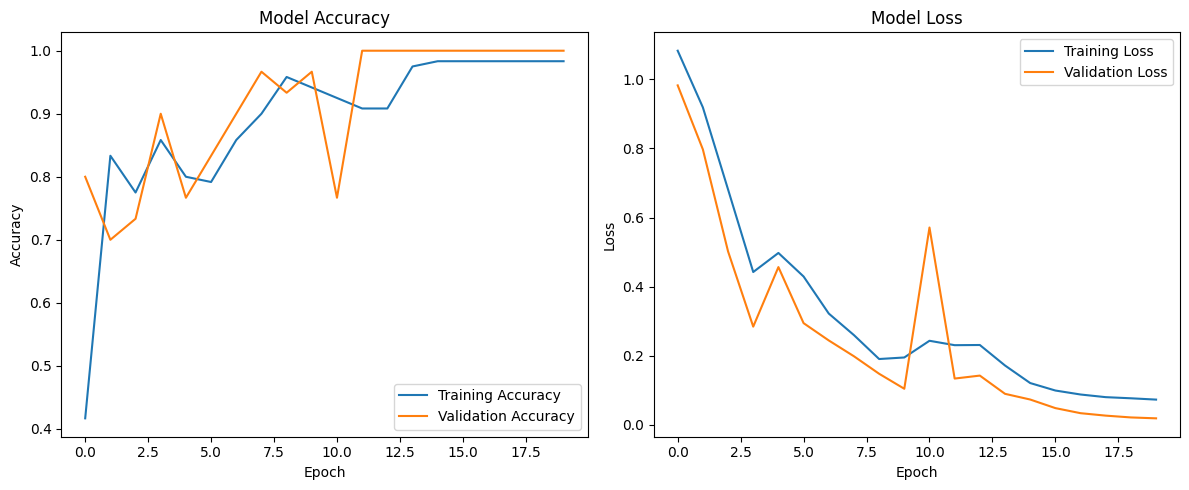

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# --- Evaluate the Model ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')
print(f'Test Loss: {loss:.4f}')

# --- Plot Training History ---
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# The model needs to be installed to save in the .h5 format
!pip install h5py

# Define a filename for your model
model_filename = 'stress_model.h5'

# Save the entire model to a single HDF5 file.
model.save(model_filename)

print(f"Model saved successfully to '{model_filename}'")

Model saved successfully to 'stress_model.h5'
